In [2]:
import glob, json, os
from PIL import Image
from tqdm import tqdm_notebook
import numpy as np
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

img_paths = glob.glob('./data/ai_challenger_caption_validation_20170910/caption_validation_images_20170910/*.jpg')
img_paths.sort()

img_paths = img_paths[:3000]
img_paths[:2]

['./data/ai_challenger_caption_validation_20170910/caption_validation_images_20170910/0003a0755539c426ecfc7ed79bc74aeea6be740b.jpg',
 './data/ai_challenger_caption_validation_20170910/caption_validation_images_20170910/000420107b8abee7c2f08bb21e4444a9d00c9323.jpg']

In [4]:
validation_annotations = json.load(
    open('./data/ai_challenger_caption_validation_20170910/caption_validation_annotations_20170910.json')
)

validation_annotations[:2]

[{'url': 'http://img5.cache.netease.com/photo/0005/2013-09-25/99LA1FC60B6P0005.jpg',
  'image_id': '3cd32bef87ed98572bac868418521852ac3f6a70.jpg',
  'caption': ['一个双臂抬起的运动员跪在绿茵茵的球场上',
   '一个抬着双臂的运动员跪在足球场上',
   '一个双手握拳的男人跪在绿茵茵的足球场上',
   '一个抬起双手的男人跪在碧绿的球场上',
   '一个双手握拳的运动员跪在平坦的运动场上']},
 {'url': 'http://img.hexun.com/2011-06-09/130363655.jpg',
  'image_id': 'fb36d921dcd9184bdd4659864fe7f3cff47accf5.jpg',
  'caption': ['房间里一个右手放在嘴角的女人和一个戴着眼镜的男人在研究仪器',
   '一个披着长发的女人和一个戴着眼镜的男人站在室内的桌子旁',
   '室内有一个戴着眼镜的男人在向一个抬起右手的女人展示东西',
   '房间里有一个左手放在盒子上的男人在给一个右手食指放在嘴边的女人展示东西',
   '一个右手放在嘴边的女人和一个戴着眼镜的男人站在房间里']}]

In [5]:
validation_annotations_dict = {x['image_id']: x['caption'][0] for x in validation_annotations}

In [6]:
img_paths_basenames = [os.path.basename(x) for x in img_paths]
img_captions = [validation_annotations_dict[x] for x in img_paths_basenames]

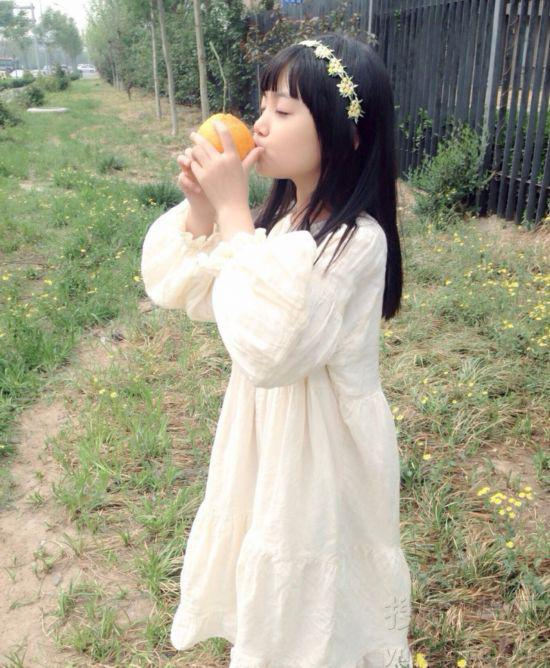

In [7]:
Image.open(img_paths[0])

In [7]:
img_captions[0]

'一个穿着裙子的女孩双手拿着东西站在宽阔的草地上'

# 加载CLIP模型

In [9]:
from PIL import Image
import requests
from transformers import ChineseCLIPProcessor, ChineseCLIPModel
import torch

model = ChineseCLIPModel.from_pretrained("./model/chinese-clip-vit-base-patch16") # 中文clip模型
processor = ChineseCLIPProcessor.from_pretrained("./model/chinese-clip-vit-base-patch16") # 预处理

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


# 图像编码

In [10]:
img_image_feat = []

batch_size = 20
for idx in tqdm_notebook(range(len(img_captions) // batch_size + 1)):
    imgs = [ Image.open(path) for path in img_paths[idx*batch_size: (idx+1)*batch_size] ]
    
    if len(imgs) == 0:
        break
    
    inputs = processor(images=imgs, return_tensors="pt")
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
        image_features = image_features.data.numpy()
        img_image_feat.append(image_features)

    break
        
img_image_feat = np.vstack(img_image_feat)
img_image_feat = normalize(img_image_feat)

/tmp/ipykernel_45095/1917125981.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx in tqdm_notebook(range(len(img_captions) // batch_size + 1)):


  0%|          | 0/151 [00:00<?, ?it/s]

In [11]:
img_image_feat.shape # 20张图片 512 维度

(20, 512)

# 文本编码

In [12]:
img_texts_feat = []

batch_size = 20
for idx in tqdm_notebook(range(len(img_captions) // batch_size + 1)):
    texts = [ text for text in img_captions[idx*batch_size: (idx+1)*batch_size] ]

    if len(texts) == 0:
        break
    
    inputs = processor(text=texts, return_tensors="pt", padding=True)

    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
        text_features = text_features.data.numpy()
        img_texts_feat.append(text_features)
    break
        
img_texts_feat = np.vstack(img_texts_feat)
img_texts_feat = normalize(img_texts_feat)

/tmp/ipykernel_45095/3623580869.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx in tqdm_notebook(range(len(img_captions) // batch_size + 1)):


  0%|          | 0/151 [00:00<?, ?it/s]

In [13]:
img_texts_feat.shape

(20, 512)

# 尝试1：相似度计算

In [15]:
query_idx = 250

sim_result = np.dot(img_texts_feat[query_idx], img_image_feat.T) # 矩阵计算
sim_idx = sim_result.argsort()[::-1][1:4]

输入文本:  宽敞的大厅里一个穿着长裙的女人抱着东西站在四个手里拿着东西的人旁边


([], [])

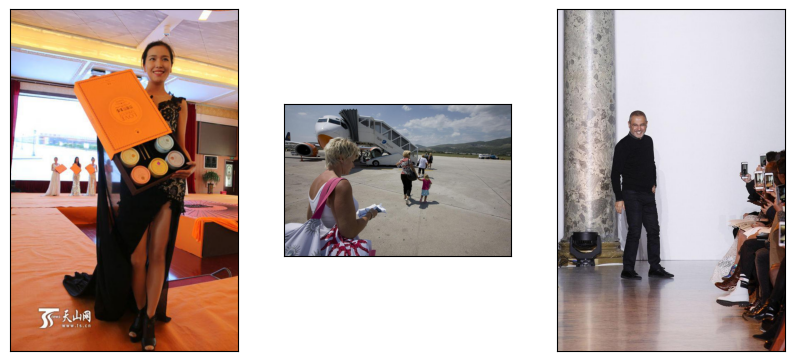

In [16]:
print('输入文本: ', img_captions[query_idx])

plt.figure(figsize=(10, 5))
plt.subplot(131)
plt.imshow(Image.open(img_paths[sim_idx[0]]))
plt.xticks([]); plt.yticks([])

plt.subplot(132)
plt.imshow(Image.open(img_paths[sim_idx[1]]))
plt.xticks([]); plt.yticks([])

plt.subplot(133)
plt.imshow(Image.open(img_paths[sim_idx[2]]))
plt.xticks([]); plt.yticks([])

In [17]:
query_idx = 250

sim_result = np.dot(img_image_feat[query_idx], img_texts_feat.T)
sim_idx = sim_result.argsort()[::-1][1:4]

文本识别结果:  ['一个右手拿着扇子的男人搂着一个弯着腰的女人站在干净的舞台上', '一个穿着裙子的女人站在背景板前的红地毯上', '一位女士抱着一个小孩子站在舞台上']


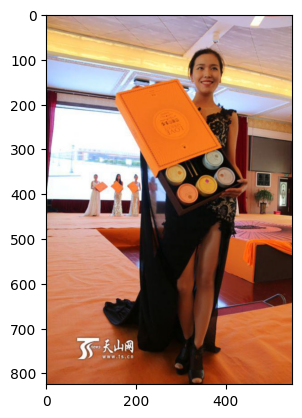

In [18]:
plt.imshow(Image.open(img_paths[query_idx]))

print('文本识别结果: ', [img_captions[x] for x in sim_idx])

# 文本标签编码

In [20]:
import jieba

In [21]:
jieba.lcut('今天天气很好，心情也很好。')

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.513 seconds.
Prefix dict has been built successfully.


['今天天气', '很', '好', '，', '心情', '也', '很', '好', '。']

In [22]:
jieba.lcut(img_captions[0])

['一个',
 '穿着',
 '裙子',
 '的',
 '女孩',
 '双手',
 '拿',
 '着',
 '东西',
 '站',
 '在',
 '宽阔',
 '的',
 '草地',
 '上']

In [23]:
img_captions2words = [jieba.lcut(x) for x in img_captions]
img_captions2words = sum(img_captions2words, [])

In [24]:
img_captions2words[:10]

['一个', '穿着', '裙子', '的', '女孩', '双手', '拿', '着', '东西', '站']

In [25]:
img_captions2words = [x for x in img_captions2words if len(x) > 1]
img_captions2words = list(set(img_captions2words))

In [26]:
img_captions2words[:10]

['琳琅满目', '起跑线', '一尘不染', '果子', '调酒', '格斗', '绶带', '房屋内', '划船', '采摘']

In [27]:
img_texts_feat = []

batch_size = 20
for idx in tqdm_notebook(range(len(img_captions2words) // batch_size + 1)):
    texts = [ text for text in img_captions2words[idx*batch_size: (idx+1)*batch_size] ]

    if len(texts) == 0:
        break
    
    inputs = processor(text=texts, return_tensors="pt", padding=True)

    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
        text_features = text_features.data.numpy()
        img_texts_feat.append(text_features)
        
img_texts_feat = np.vstack(img_texts_feat)
img_texts_feat = normalize(img_texts_feat)

/tmp/ipykernel_1185/3640130202.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx in tqdm_notebook(range(len(img_captions2words) // batch_size + 1)):


  0%|          | 0/82 [00:00<?, ?it/s]

# 尝试2：标签相似度计算

In [28]:
query_idx = 120

sim_result = np.dot(img_image_feat[query_idx], img_texts_feat.T)
sim_idx = sim_result.argsort()[::-1][1:7]

文本识别结果:  ['小姑娘', '稚嫩', '小女孩', '嬉笑', '里教', '淹没']


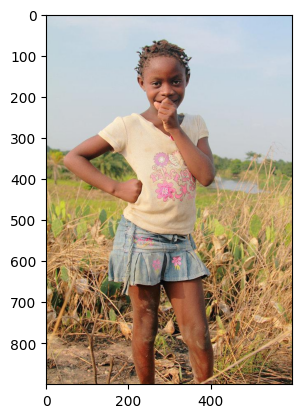

In [29]:
plt.imshow(Image.open(img_paths[query_idx]))

print('文本识别结果: ', [img_captions2words[x] for x in sim_idx])